# Линейные уравнения мелкой воды

Простейшая модель волнового движения в атмосфере - линейная модель мелкой воды. Эта модель описывает эволюцию маленьких возмущений высоты поверхности на большом горизонтальном масштабе. В одномерном случае, она записывается так
$$
\Large
\begin{cases}
\frac{\partial u}{\partial t} = -g \frac{\partial h}{\partial x}, \\
\frac{\partial h}{\partial t} = -H \frac{\partial u}{\partial x},
\end{cases}
$$
где $g$ - ускорение свободного падения, $H$ - средняя глубина жидкости, $u$ - скорость течения, $h$ - возмущение глубины. Для физической корректности системы должны выполняться следующие условия: $h<<H<<L$, где $L$ - горизонтальный масштаб. Для изучения численных методов, физическая корректность необязательна :-).

Граничные условия будем рассматривать аналитические.

### Аналитическое решение
Если первое уравнение системы продифференцировать по $x$, а второе по $t$ и исключить $u$ из второго уравнения, то получится волновое уравнение для $h$:
\begin{equation}
\frac{\partial^2 h}{\partial t^2} = gH\frac{\partial^2 h}{\partial x^2}.
\end{equation}

Общее решение волнового уравнения - сумма волны, бегущей направо, и волны, бегущей налево:
\begin{equation}
h(x,t) = c_1 h_0(x-ct)+c_2 h_0(x+ct),
\end{equation}
где $h_0$ - начальные условия $h$, $c=\sqrt{gH}$ - фазовая скорость, константы $a_1$ и $a_2$ - определяются вторым начальным условием (на $u$ или на $\partial h/\partial t$). Когда $u(t=0)$, $a_1 = a_2 = 1/2$.

# Численное решение

Для численного решения будем пользоваться "методом линий". Сначала проведем дискретизацию по пространству и получим систему ОДУ, потом будет ее интегрировать по времени.

Рассмотрим простейший вариант для аппроксимации этого уравнения. 
Для аппроксимации по времени можем воспользоваться явным методом Эйлера:
$$
\Large
\begin{cases}
\frac{u^{n+1}(x)-u^n(x)}{\Delta t} + g \left(\frac{\partial h}{\partial x}\right)^n=0, \\
\frac{h^{n+1}(x)-h^n(x)}{\Delta t} + H \left(\frac{\partial u}{\partial x}\right)^n=0
\end{cases}
$$
Для аппроксимации по пространству можно использовать:
\begin{align}
\large
\left(\frac{\partial u}{\partial x}\right)^n \approx \frac{u^n_{i+1}-u^n_{i-1}}{2\Delta x}.
\end{align}
Собирая все вместе, получаем следующую схемы
$$
\Large
\begin{cases}
\frac{u^{n+1}_i-u^n_i}{\Delta t} + g \frac{h^n_{i+1}-h^n_{i-1}}{2\Delta x}=0, \\
\frac{h^{n+1}_i-h^n_i}{\Delta t} + H \frac{u^n_{i+1}-u^n_{i-1}}{2\Delta x}=0
\end{cases}
$$

Перейдем к программной реализации. Будем использовать равномерную сетку на периодическом отрезке $x \in [0,L)$. Количество узлов сетки $N_x+1$, шаг сетки $\Delta x = L/N_x$, узлы сетки $x_i = (i-1)\Delta x$, $i=0 \dots N_x$. Решаем уравнение при $t \in [0, T]$, количество шагов по времени $N_t$, $t_n = (n-1) \Delta t$, $n=0 \dots N_t$.

In [1]:
# Подключаем необходимые пакеты
import numpy as np    
import matplotlib.pyplot  as plt
from matplotlib import animation
%matplotlib notebook

Реализуем процедуру для вычисления производной по пространству.

In [2]:
def centralDifference(f, dx):
    diff_f = np.empty_like(f)
    for i in range(1, f.size - 1):
        diff_f[i] = (f[i+1] - f[i-1]) / 2 / dx
    diff_f[-1] = (f[1] - f[-2]) / 2 / dx    
    diff_f[0] = diff_f[-1] # т.к. отрезок периодический x0 = xn, f'_0 = f'_n
    return diff_f

In [3]:
def central4Difference(f, dx):
    diff_f = np.empty_like(f)
    for i in range(1, f.size - 2):
        diff_f[i] = (-f[i+2] + 8*f[i+1] - 8*f[i-1] + f[i-2]) / 12 / dx
    diff_f[-1] = (-f[2] + 8*f[1] - 8*f[-2] + f[-3]) / 12 / dx   
    diff_f[-2] = (-f[1] + 8*f[-1] - 8*f[-3] + f[-4]) / 12 / dx  
    diff_f[0] =  (-f[2] + 8*f[1] - 8*f[-2] + f[-3]) / 12 / dx # т.к. отрезок периодический x0 = xn, f'_0 = f'_n
    diff_f[1] =  (-f[3] + 8*f[2] - 8*f[0] + f[-2]) / 12 / dx # т.к. отрезок периодический x0 = xn, f'_0 = f'_n
    return diff_f

Функция для выполнения шага по времени при помощи явного метода Эйлера.

In [4]:
def explicitEulerStep(state, func, dt):
    return state + dt*func(state) 

In [5]:
def RK4(state, calcRHS, dt):
    k1 = calcRHS(state)
    k2 = calcRHS(state + dt/2*k1)
    k3 = calcRHS(state + dt/2*k2)
    k4 = calcRHS(state + dt*k3)
    return state + dt/6*(k1+2*k2+2*k3+k4)

Функция для решения уравнений мелкой воды. 

In [6]:
def solveShallowWater(u0, h0, timeMethod, spaceMethod, nx = 100, nt = 200, L = 1.0, T = 1.0, g = 1.0, H = 1.0):
    """
    Входные аргументы:
    u0, h0 -- функции для вычисления начального значения u(t=0,x), h(t=0,x)
    timeMethod -- функция, метод интегрирования по времени
    spaceMethod -- функция, метод аппроксимации du/dx, dh/dx
    nx -- индекс последнего узла сетки x_i по пространству. i = 0 ... nx, x_0 = x_nx, т.к. отрезок периодический.
    nt -- индекс последнего узла сетки t_i по времени. i = 0 ... nt, t_nt = T
    L -- длина отрезка по пространству
    T -- до какого момента времени производить интегрирование
    g, H -- константы уравнений
    """
    
    # параметры пространственной сетки
    dx = L / nx
    x = np.arange(0, nx + 1) * dx
    # параметры временной сетки
    dt = T / nt
    t = np.arange(0, nt + 1) * dt
    # определяем скорость распространения гравитационных волн и число Куранта
    с = np.sqrt(g * H)
    CFL = с * dt / dx
    #print(f"Число Куранта CFL = {CFL}")
    
    # инициализируем массивы для хранения численного и точного решения во все моменты времени
    state  = np.zeros((nt+1, 2*(nx+1)))
    stateExact = np.zeros((nt+1, 2*(nx+1)))
    
    # задаем значения в начальный момент времени
    state[0,:] = np.concatenate((u0(x), h0(x)))
    stateExact[0,:] = state[0,:]
    
    # определяем функцию для вычисления правой части системы уравнений
    calcRhs = lambda f: np.concatenate( (-g * spaceMethod(f[nx+1:], dx), -H * spaceMethod(f[:nx+1], dx) ) )
    
    # цикл по времени
    for k in range(nt):
        state[k+1,:] = timeMethod(state[k,:], calcRhs, dt)
        
        stateExact[k+1,:nx+1] = 0.5 * ( u0((x - с * t[k+1])%np.max(x)) + \
                                        u0((x + с * t[k+1])%np.max(x)) + \
                                        np.sqrt(g / H)*h0((x - с * t[k+1])%np.max(x)) - \
                                        np.sqrt(g / H)*h0((x + с * t[k+1])%np.max(x)))
        
        stateExact[k+1,nx+1:] = 0.5 * ( np.sqrt(H / g)*u0((x - с * t[k+1])%np.max(x)) - \
                                        np.sqrt(H / g)*u0((x + с * t[k+1])%np.max(x)) + \
                                        h0((x - с * t[k+1])%np.max(x)) + \
                                        h0((x + с * t[k+1])%np.max(x)))
        
    return state, stateExact, x, t

Функции для задания начального профиля.

In [7]:
def gaussianHill(x, mean = 0.5, sigma = 10):
    return np.exp(-sigma**2*(x-mean)**2)

In [8]:
def step(x):
    return np.logical_and(x>=3.0 / 8, x <= 5.0 / 8)

Функция для отрисовки численного и точного решения

In [9]:
def animateShallowWater(state, stateExact, x, t, animSpeed = 1):

    nx = x.size - 1
    
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(8, 3)

    line1, = ax1.plot(x, state[0,nx+1:], label = "Numerical Solution")
    line2, = ax1.plot(x, stateExact[0,nx+1:], label = "Exact Solution")
    line3, = ax2.plot(x, state[0,:nx+1])
    line4, = ax2.plot(x, stateExact[0,:nx+1]) 
    lines = (line1, line2, line3, line4)
    
    ax1.set_title("Height field, h")
    ax2.set_title("Velocity field, u")
    
    fig.legend(loc = 8, ncol = 2)
    
    fig.tight_layout()
    fig.subplots_adjust(bottom=0.2)
    
    height = np.max(np.abs(stateExact[:,nx+1:]))
    ax1.set_ylim(np.min(stateExact[0,nx+1:]) - 0.2 * height, np.max(stateExact[0,nx+1:]) + 0.2 * height)
    height = np.max(np.abs(stateExact[:,:nx+1]))
    ax2.set_ylim(np.min(stateExact[:,:nx+1]) - 0.2 * height, np.max(stateExact[:,:nx+1]) + 0.2 * height)
    
    time_template = 'time = %.2fs'
    time_text = ax1.text(0.05, 0.9, '', transform=ax1.transAxes)
    
    def animate(n):
        nAnim = animSpeed * n
        
        lines[0].set_ydata(state[nAnim,nx+1:])
        lines[1].set_ydata(stateExact[nAnim,nx+1:])
        
        lines[2].set_ydata(state[nAnim,:nx+1])
        lines[3].set_ydata(stateExact[nAnim,:nx+1])
        
        time_text.set_text(time_template % (t[nAnim]))
        return lines, time_text

    anim = animation.FuncAnimation(fig, animate, frames=len(t), interval=1, repeat = False, blit=True)
    plt.show()

    return anim

In [11]:
u, uExact, x, t = solveShallowWater(u0 = lambda x: np.zeros(x.size), h0 = gaussianHill, \
                                    timeMethod = explicitEulerStep, spaceMethod = leftDifference, \
                                    nx = 1000, nt = 16000, g = 1, H = 1, T=1)
anim = animateShallowWater(u, uExact, x, t, 4)

NameError: name 'leftDifference' is not defined

# Упражнения/задания

**Упражнение 1** Решите систему методами PK4+центральная разность второго порядка, РК4+центральная разность 4-го порядка.

**Упражнение 2** Исследуйте ошибку численного решения схем, сходимость.

**Упражнение 3** Можно ли использовать направленные разности (левую или правую) для решения этой системы уравнений?

**Упражнение 4** Пусть $\Delta x$ - шаг сетки, $u_0(x) = 0$, $h_0(x) = \cos(\pi/\Delta x \cdot x)$. Посмотрите численное решение. Как вы думаете, почему оно такое?

<IPython.core.display.Javascript object>


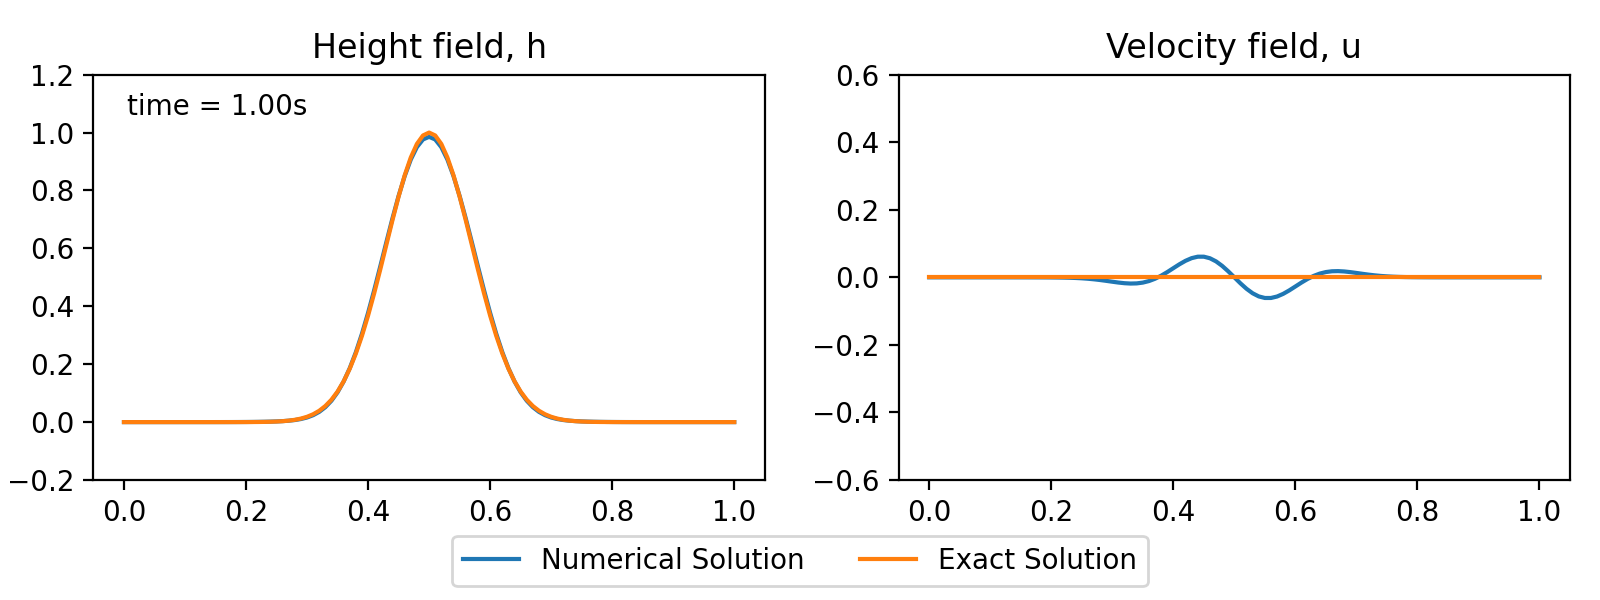

In [171]:
#упражнение 1.1.
uRK4C2, uExact, x, t = solveShallowWater(u0 = lambda x: np.zeros(x.size), h0 = gaussianHill, \
                                    timeMethod = RK4, spaceMethod = centralDifference, \
                                    nx = 100, nt = 1600, g = 1, H = 1, T=1)
anim = animateShallowWater(uRK4C2, uExact, x, t, 4)

<IPython.core.display.Javascript object>


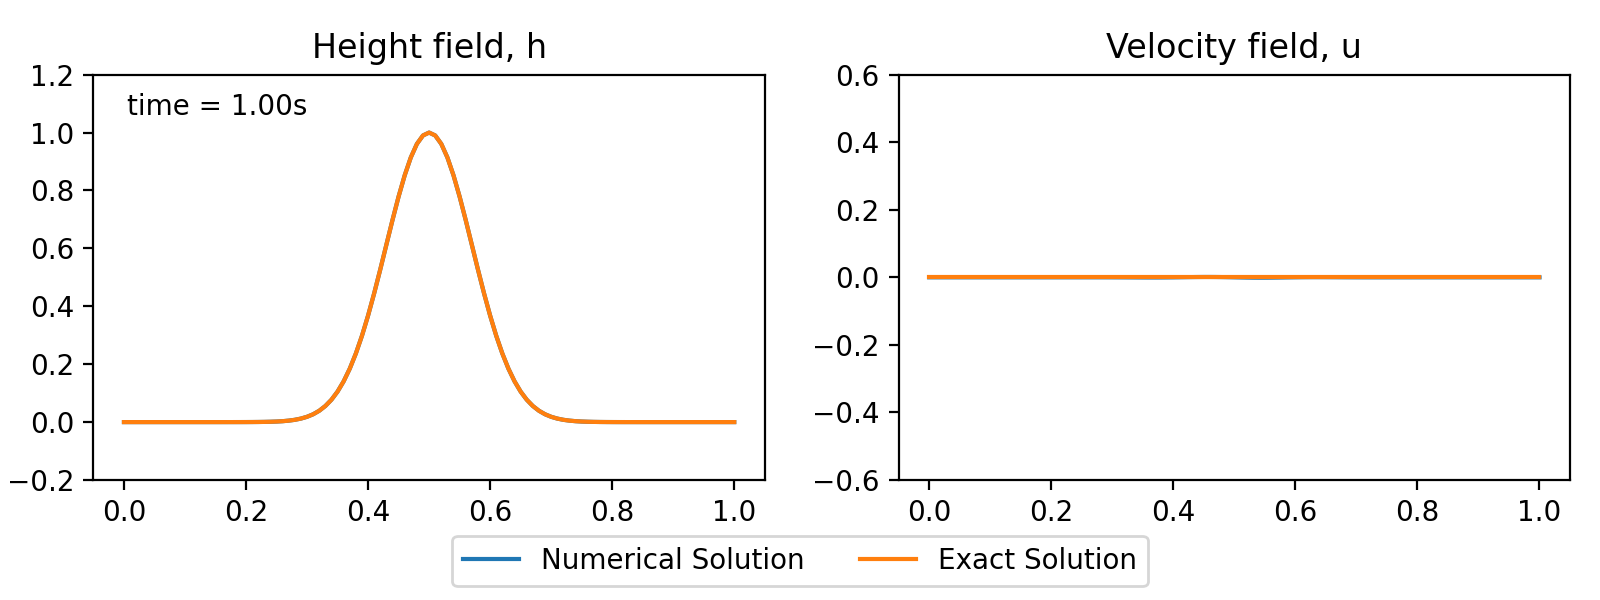

In [172]:
#упражнение 1.2.
uRK4C4, uExact, x, t = solveShallowWater(u0 = lambda x: np.zeros(x.size), h0 = gaussianHill, \
                                    timeMethod = RK4, spaceMethod = central4Difference, \
                                    nx = 100, nt = 1600, g = 1, H = 1, T=1)
anim = animateShallowWater(uRK4C4, uExact, x, t, 4)

In [173]:
#упражнение 2.1.
errorEulerCenter2 = u[-1]    - uExact[-1]
errorRK4Center2   = uRK4C2[-1] - uExact[-1]
errorRK4Center4   = uRK4C4[-1] - uExact[-1]

print(np.sqrt(errorEulerCenter2@errorEulerCenter2))
print(np.sqrt(errorRK4Center2@errorRK4Center2))
print(np.sqrt(errorRK4Center4@errorRK4Center4))

0.3253653619466881
0.2259745781145699
0.0035804597577922303


In [174]:
#упражнение 2.2.
N = 7
errorEulerCenter2 = np.zeros(N)
errorRK4Center2   = np.zeros(N)
errorRK4Center4   = np.zeros(N)
h_array           = np.zeros(N)

for i in range(N):
    cx = 20*2**i
    ct = 40*2**i
    u, uExactEC2, x, t = solveShallowWater(u0 = lambda x: np.zeros(x.size), h0 = gaussianHill, \
                                    timeMethod = explicitEulerStep, spaceMethod = centralDifference, \
                                    nx = cx, nt = ct, g = 1, H = 1, T=1)
    uRK4C2, uExactRK4C2, x, t = solveShallowWater(u0 = lambda x: np.zeros(x.size), h0 = gaussianHill, \
                                    timeMethod = RK4, spaceMethod = centralDifference, \
                                    nx = cx, nt = ct, g = 1, H = 1, T=1)
    uRK4C4, uExactRK4C4, x, t = solveShallowWater(u0 = lambda x: np.zeros(x.size), h0 = gaussianHill, \
                                    timeMethod = RK4, spaceMethod = central4Difference, \
                                    nx = cx, nt = ct, g = 1, H = 1, T=1)
    h_array[i]           = 1/cx
    errorEulerCenter2[i] = np.sqrt((u[-1] - uExactEC2[-1])@(u[-1] - uExactEC2[-1])/cx)
    errorRK4Center2[i]   = np.sqrt((uRK4C2[-1] - uExactRK4C2[-1])@(uRK4C2[-1] - uExactRK4C2[-1])/cx)
    errorRK4Center4[i]   = np.sqrt((uRK4C4[-1] - uExactRK4C4[-1])@(uRK4C4[-1] - uExactRK4C4[-1])/cx)

<IPython.core.display.Javascript object>


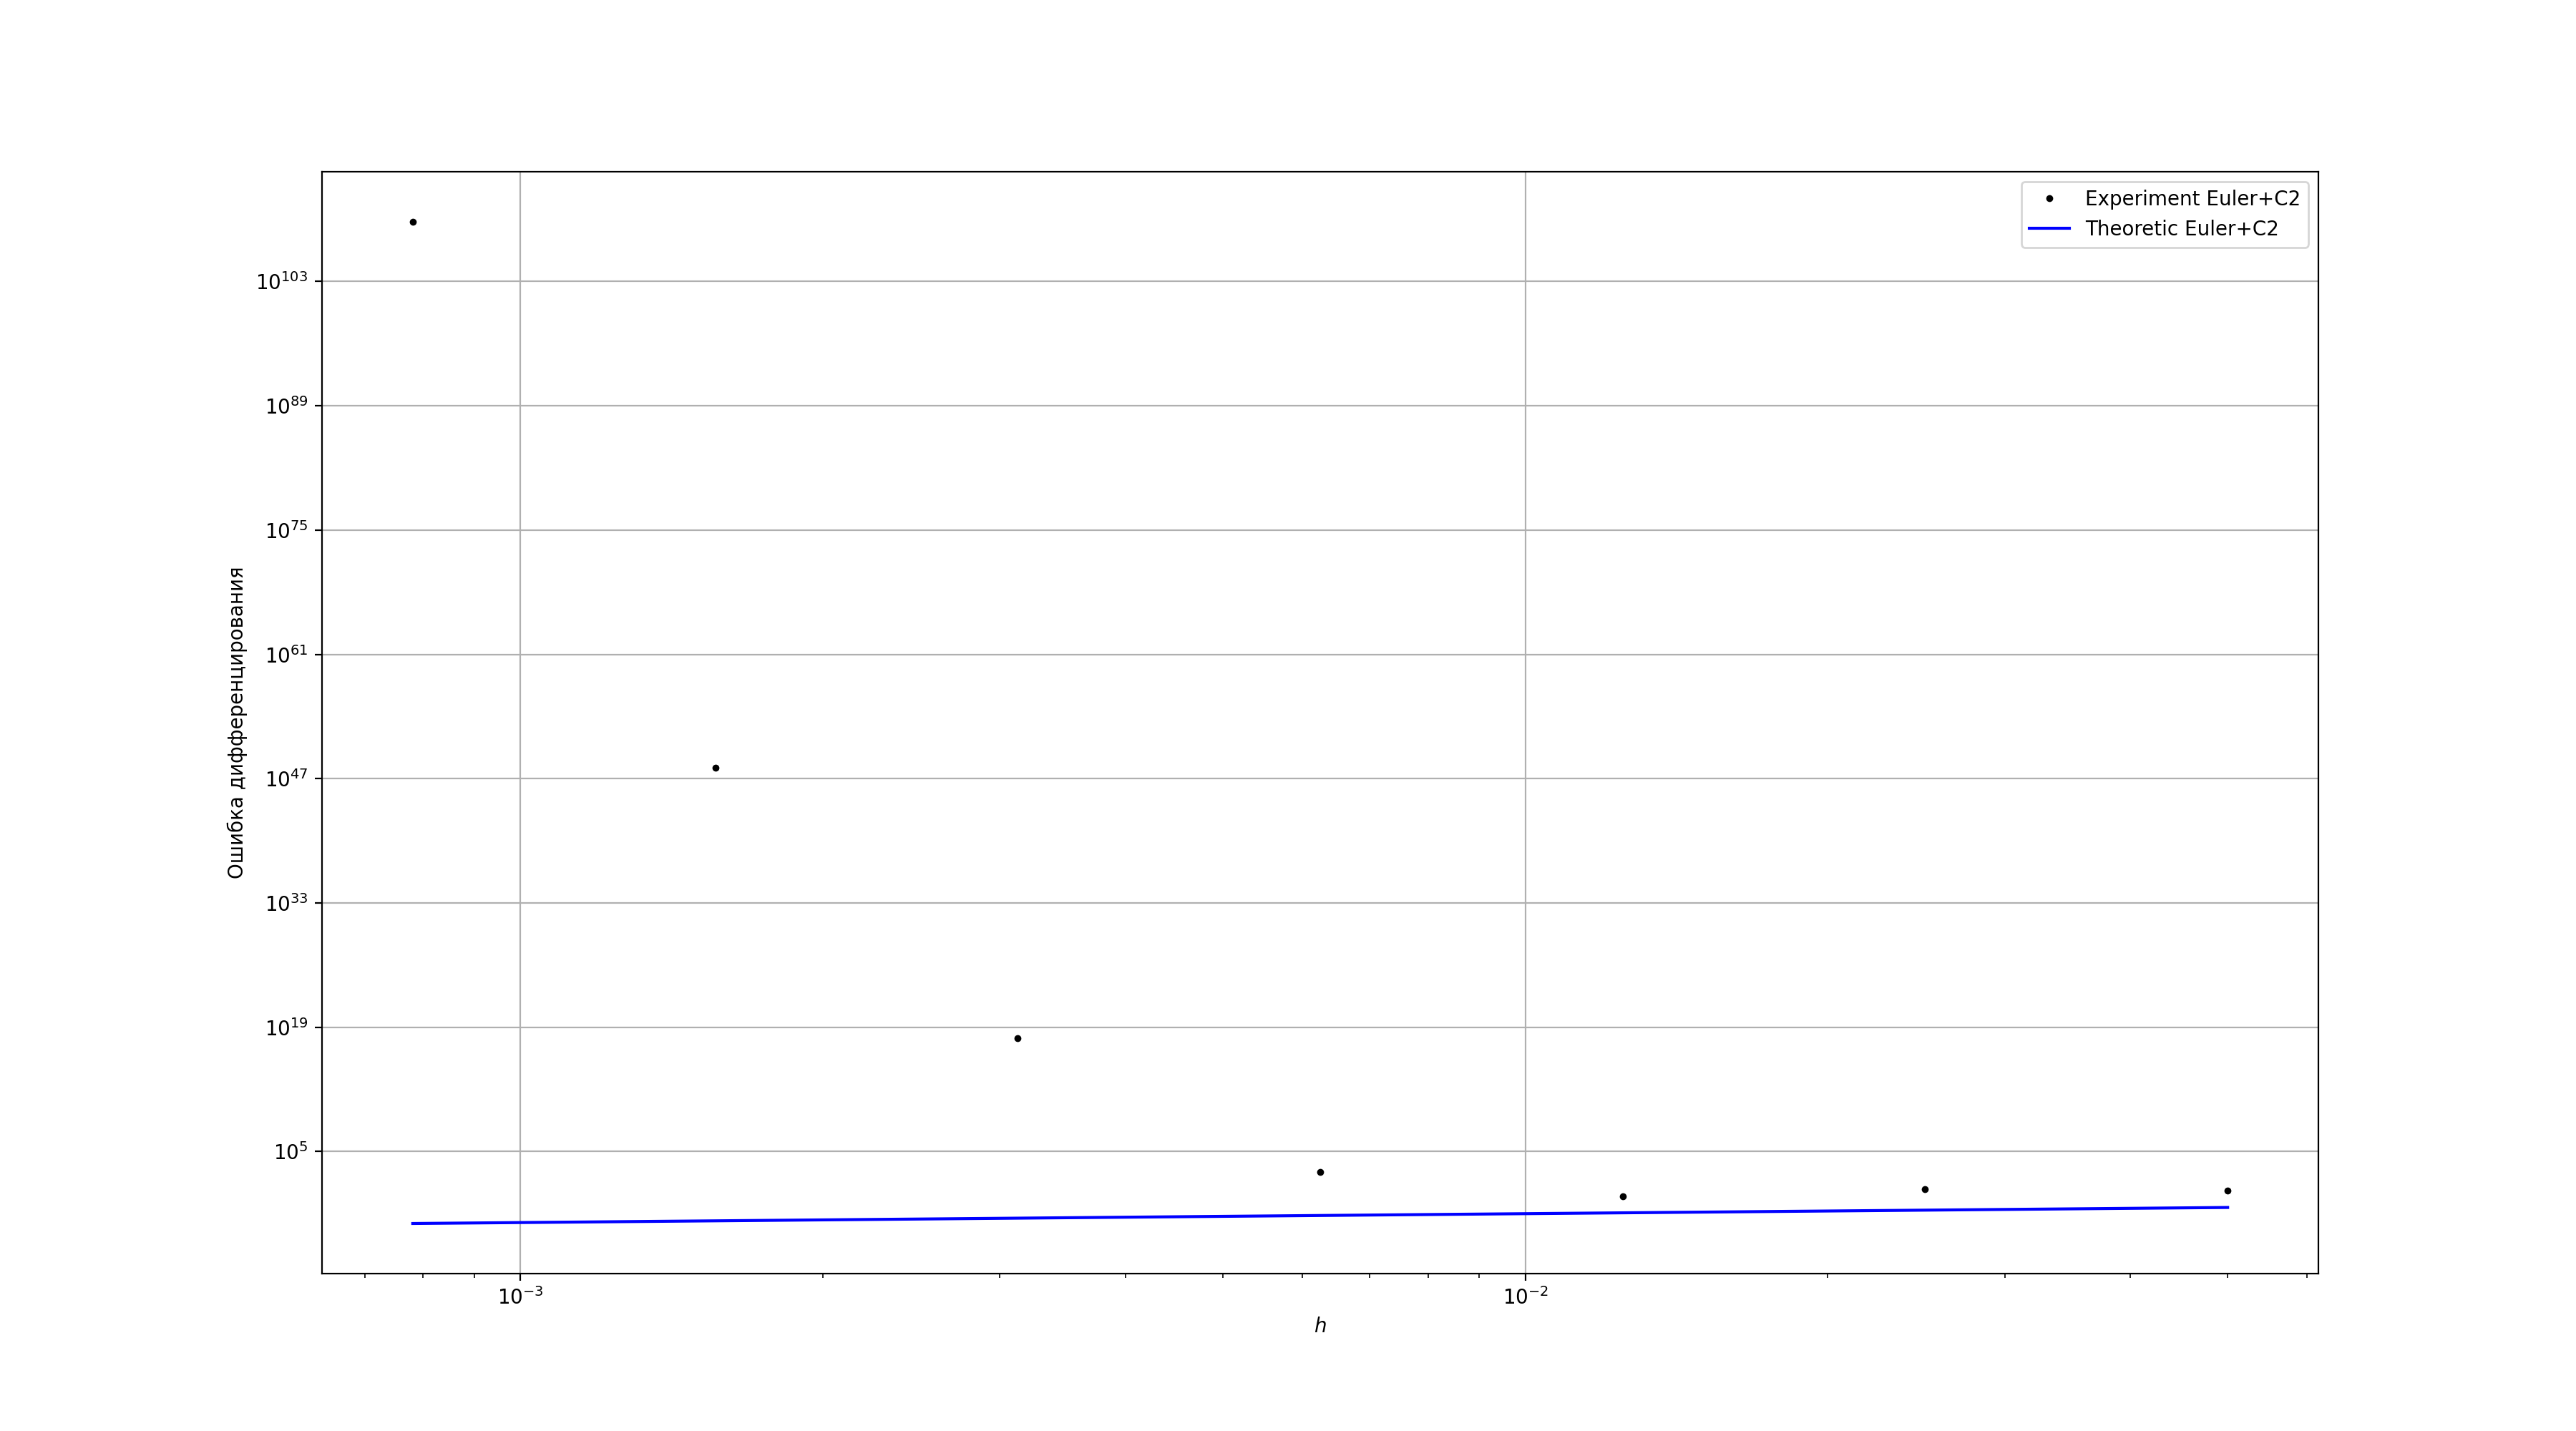

In [178]:
plt.figure(figsize=(18, 10))
plt.loglog(h_array, errorEulerCenter2, 'k.', ms=5, label='Experiment Euler+C2')
plt.loglog(h_array, h_array, 'b-', ms=5, label='Theoretic Euler+C2')
plt.grid()

plt.xlabel('$h$')
plt.ylabel('Ошибка дифференцирования')
plt.legend()

plt.show()

<IPython.core.display.Javascript object>


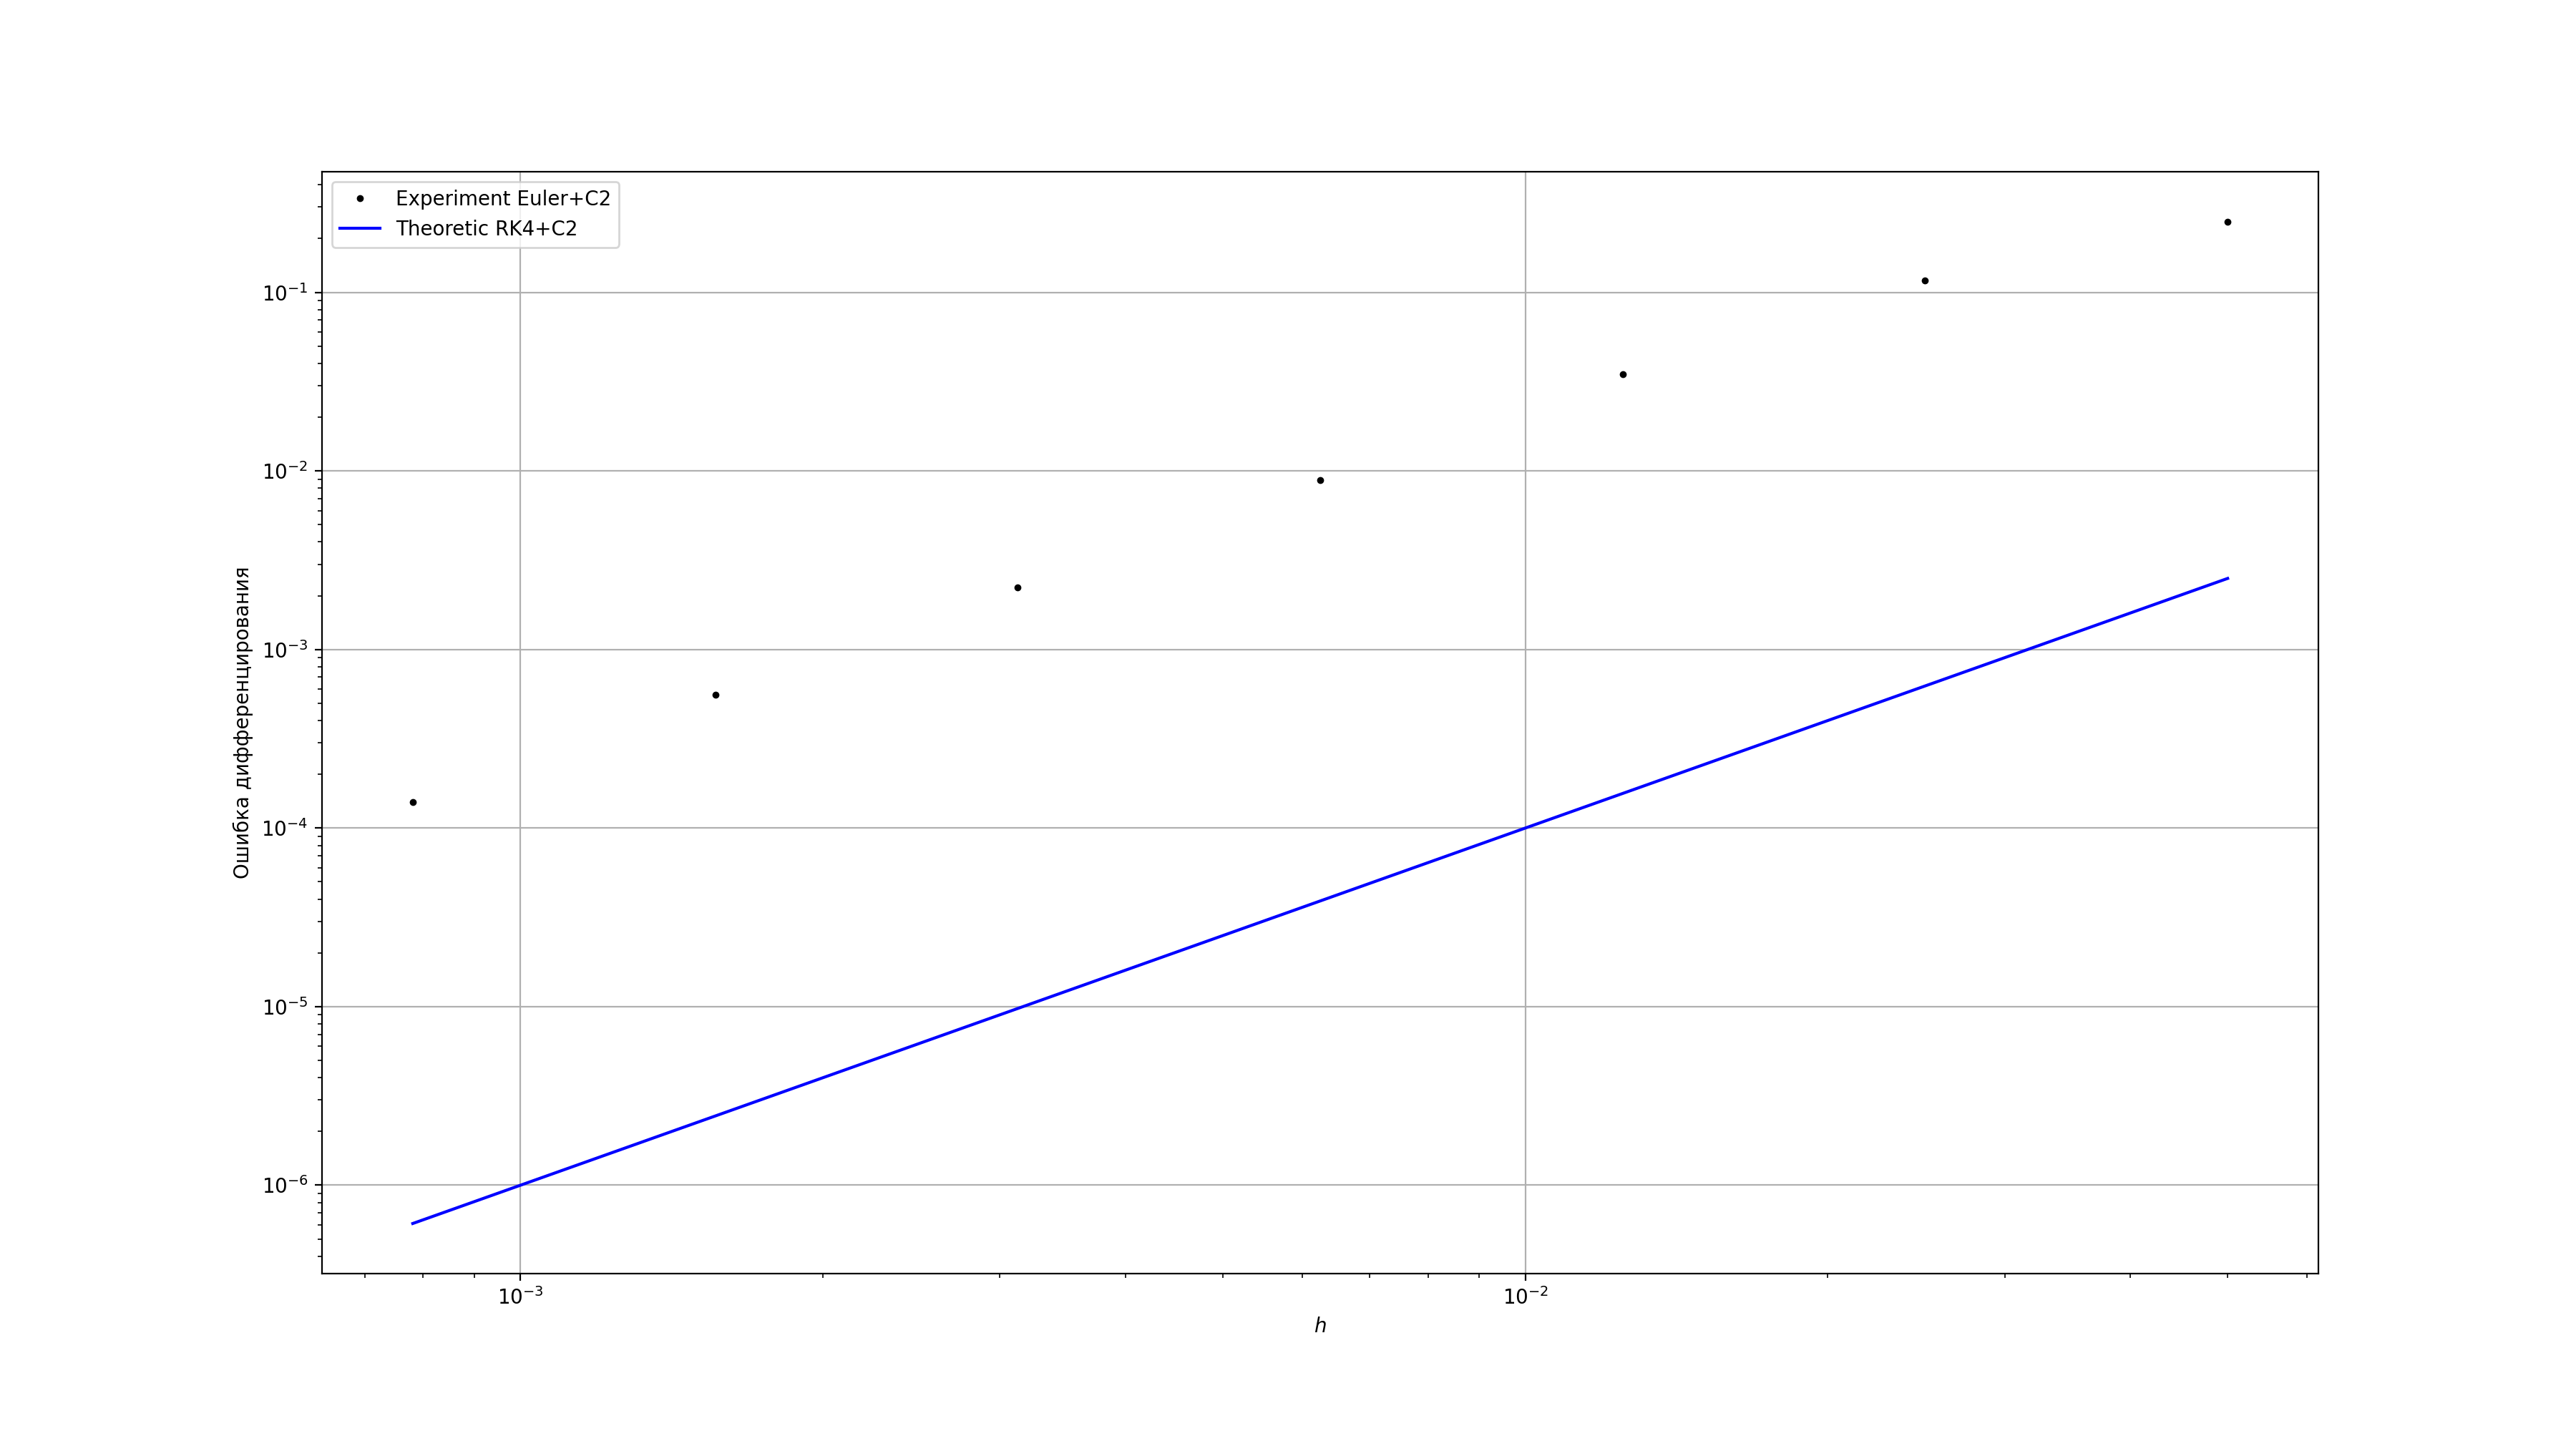

In [179]:
plt.figure(figsize=(18, 10))
plt.loglog(h_array, errorRK4Center2, 'k.', ms=5, label='Experiment Euler+C2')
plt.loglog(h_array, h_array**2, 'b-', ms=5, label='Theoretic RK4+C2')
plt.grid()

plt.xlabel('$h$')
plt.ylabel('Ошибка дифференцирования')
plt.legend()

plt.show()

<IPython.core.display.Javascript object>


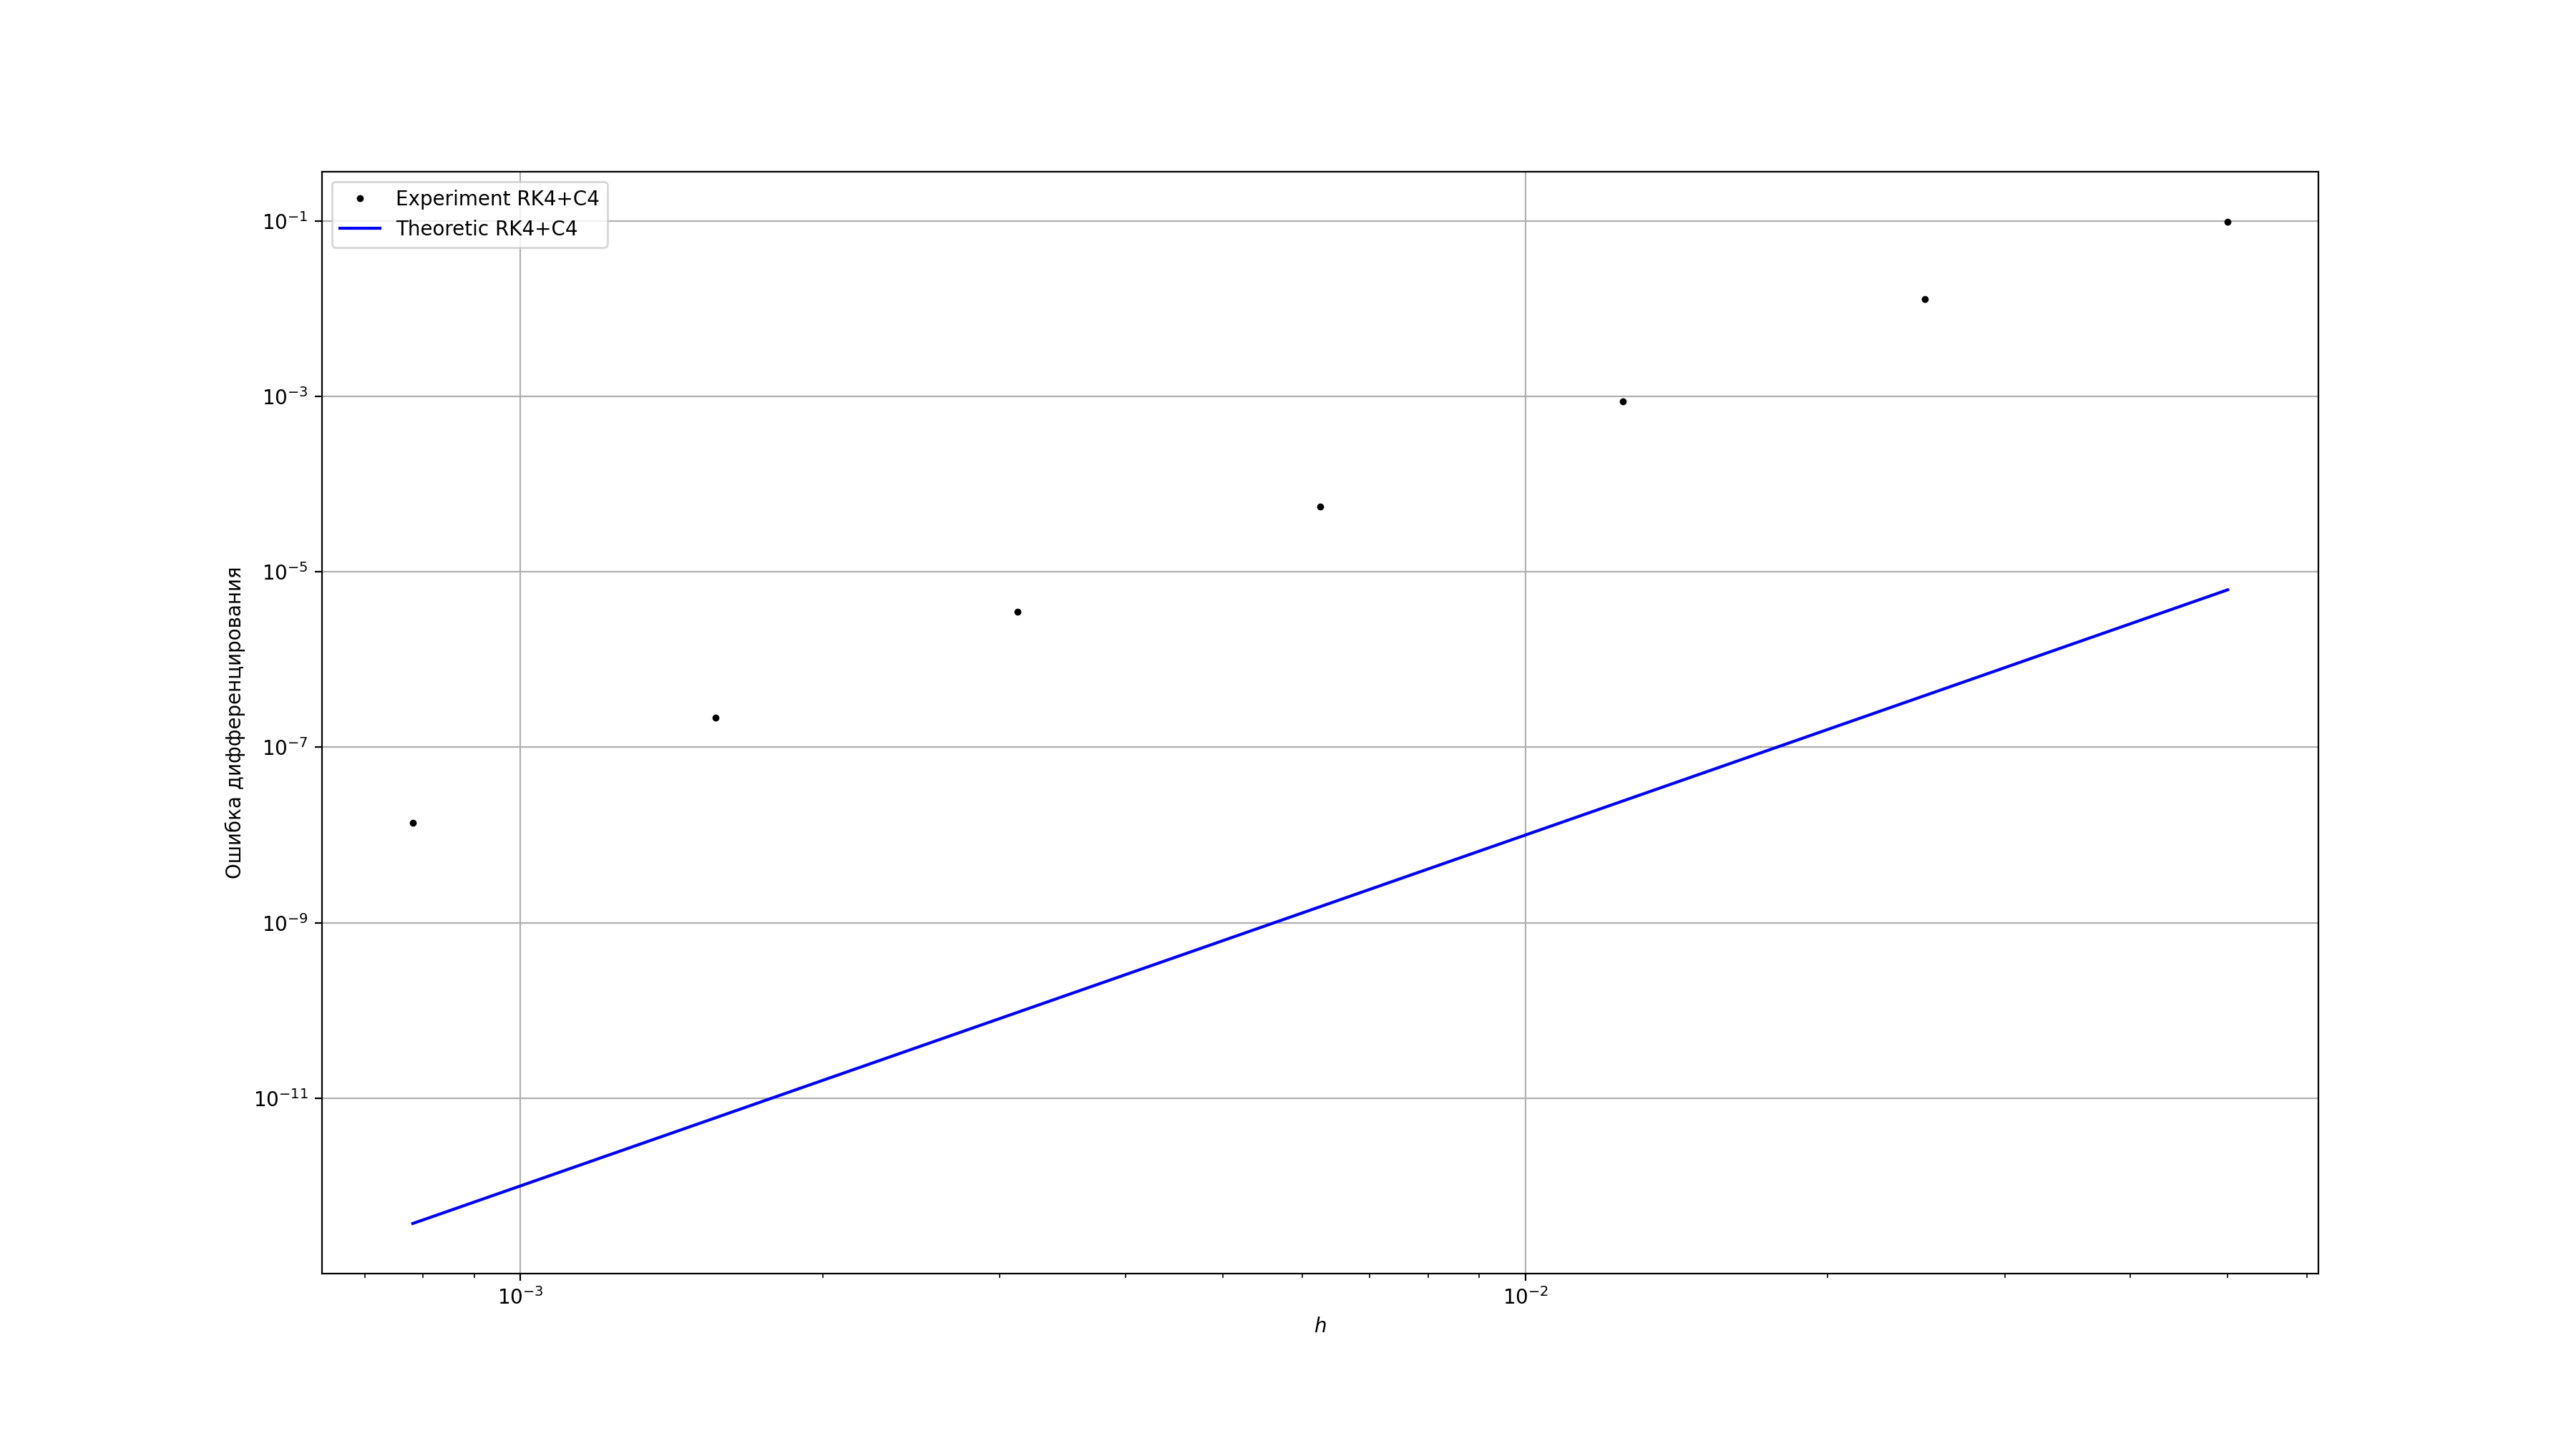

In [180]:
plt.figure(figsize=(18, 10))
plt.loglog(h_array, errorRK4Center4, 'k.', ms=5, label='Experiment RK4+C4')
plt.loglog(h_array, h_array**4, 'b-', ms=5, label='Theoretic RK4+C4')
plt.grid()

plt.xlabel('$h$')
plt.ylabel('Ошибка дифференцирования')
plt.legend()

In [186]:
#Упражнение 3.
#Нельзя! Поскольку перенос по полю скоростей происходит в обе стороны

<IPython.core.display.Javascript object>


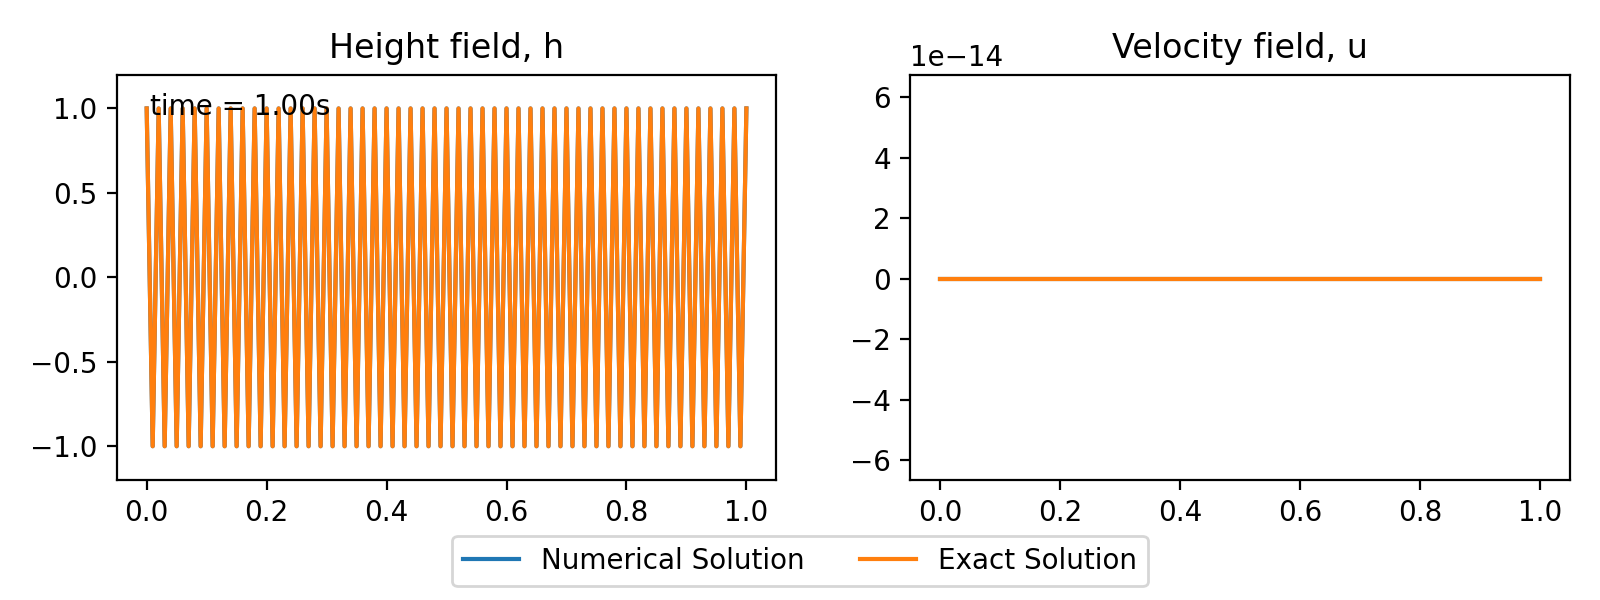

In [13]:
#упражнение 4.
u, uExact, x, t = solveShallowWater(u0 = lambda x: np.zeros(x.size), h0 = lambda x: np.cos(np.pi*100*x), \
                                    timeMethod = RK4, spaceMethod = centralDifference, \
                                    nx = 100, nt = 1600, g = 1, H = 1, T=1)
anim = animateShallowWater(u, uExact, x, t, 4)

In [14]:
# Частота косинуса равна частоте Найквиста, которой достигать для дискретизации нельзя!!!